                 "پیش‌بینی پاتولوژیک بودن جهش‌های ژنوم میتوکندریایی با استفاده از مدل‌های یادگیری ماشین"

Currently, determining the pathogenicity of mutations in mitochondrial DNA (mtDNA) relies on time-consuming and costly biological experiments. This project aims to develop a computational tool using available datasets and Machine Learning models to address this challenge.

The workflow is as follows:
*   **Input:** Mutation characteristics (e.g., location, type, amino acid change, etc.)
*   **Output:** Prediction of status (Benign / Pathogenic)

| parameter      | description                                           |
| --------- | ----------------------------------------------- |
|Target organism |homo sapiens                                   |
|Data Type  | **mtDNA mutations**                             |
|Model Output | **Binary Classification** → Benign / Pathogenic |                        |



Data Collection & Preparation
File: variant_summary.txt.gz

This file is one of the primary output files from the ClinVar database. It contains structural and clinical information regarding thousands of human genetic variants.

A key column in this file specifies the clinical significance for each variant, indicating whether it is:

Pathogenic (Disease-causing)
Benign (Harmless)
Uncertain Significance (e.g., Likely pathogenic, Uncertain significance)
                                            

  ستون های مورد توجه :
  | Column                   | Description                                                              |
| ---------------------- | ------------------------------------------------------------------ |
| `Chromosome`           |Chromosome number (For mtDNA, this value is usually MT). |
| `Start`, `Stop`        | Exact location of the mutation in the genome sequence.                                        |
| `Type`                 |Type of variant (e.g., SNV = Single Nucleotide Variant). Variant)                |
| `Name`                 |Standard mutation nomenclature (e.g., m.3243A>G). `m.3243A>G`)                               |
| `GeneSymbol`           |Gene name (e.g., MT-ND1, MT-TL1).                                 |
| `ClinicalSignificance` |Pathogenicity label (Benign, Pathogenic, etc.).                      |
| `ReviewStatus`         |Quality of clinical interpretation (Review status/Star rating).                        |
| `Assembly`             | Reference genome assembly version (e.g., GRCh38).                                     |
| `RS# (dbSNP)`          | 	dbSNP ID (if the variant is registered in dbSNP).                 |



Preprocessing and Filtering of mtDNA Data from ClinVar

We extracted only human mitochondrial mutations that met specific criteria:

Location: Located in the mitochondrial DNA (mtDNA).

Clinical Significance: Labeled as either Benign or Pathogenic (Selected specifically for Binary Classification).

In [ ]:
import pandas as pd

# Load the compressed file directly
df = pd.read_csv("variant_summary.txt.gz", sep='\t', compression='gzip', low_memory=False)

# Filter for mitochondrial mutations labeled as Benign or Pathogenic
df_mt = df[
    (df['Chromosome'] == 'MT') &
    (df['ClinicalSignificance'].isin(['Benign', 'Pathogenic']))
]

# Select relevant columns
columns_to_keep = ['Name', 'Type', 'GeneSymbol', 'Start', 'Stop', 'ClinicalSignificance']
df_mt = df_mt[columns_to_keep]

# Save the filtered dataframe to CSV
df_mt.to_csv("filtered_mtDNA_variants.csv", index=False)

print(f"✅ Number of extracted mutations: {len(df_mt)}")



| Parameter                 | Description                                    |
| -------------------- | ------------------------------------------- |
| `compression='gzip'` | Instructs Pandas that the file is gzip compressed.       |
| `low_memory=False`   | Prevents "mixed types" error during loading.        |
| `Chromosome == 'MT'` | Keeps only mitochondrial variants. |


استخراج ویژگی‌ها (Feature Engineering)
| Column            | 	Extractable Feature                                     |
| --------------- | -------------------------------------------------------- |
| `Type`          | Mutation type (SNV, deletion, etc.) ← Numerical encoding or One-hot encoding.   |
| `GeneSymbol`    |Gene name ← Can imply functional role.                  |
| `Start`, `Stop` |Numerical position of mutation ← May indicate sensitive sites or hotspots.     |
| `Name`          |Usable for extracting change type (e.g., A>G, T>C). |


Engineered Features
Mutation_Type ← Derived from column Type
(e.g., single nucleotide variant, deletion)

Gene ← Derived from column GeneSymbol
(Encoded using One-hot or LabelEncoder)

Position ← Derived from column Start
(Numerical value of location on mtDNA)

Nucleotide_Change ← Extracted from column Name
Example: from m.3243A>G → Create new columns: Ref_Nuc = A, Alt_Nuc = G

Target ← Derived from ClinicalSignificance
Model Labels: Benign → 0, `Pathogenic → 1

 ##  Feature Engineering
Transforming raw textual data (such as gene names or mutation types) into numerical features that are interpretable by machine learning models.


In [ ]:
# Initial Setup
import pandas as pd

# Loading the filtered data
df = pd.read_csv("filtered_mtDNA_variants.csv")
df.head(3)


Feature: Position ← From column Start

Since Start indicates the mutation location on the mtDNA, 

it is used directly as a numerical feature:


In [ ]:

df['Position'] = df['Start']


In [ ]:
# Mutation_Type <- Derived from column 'Typee
from sklearn.preprocessing import LabelEncoder

le_type = LabelEncoder()
df['Mutation_Type_Encoded'] = le_type.fit_transform(df['Type'])


In [ ]:
#Feature: GeneSymbol <- Converting gene names to numerical codes
le_gene = LabelEncoder()
df['Gene_Encoded'] = le_gene.fit_transform(df['GeneSymbol'].astype(str))

In [ ]:
# Nucleotide Features <- Extracted from column 'Name'
# If mutation names follow the format m.3243A>G, we can separate the nucleotide change:
def extract_nucs(name):
    try:
        if 'm.' in name and '>' in name:
            # پیدا کردن فقط بخش m.XXXXA>G
            m_index = name.index('m.')
            m_part = name[m_index + 2:]  # حذف "m." و برداشتن بقیه
            if '>' in m_part:
                change = m_part.split('>')
                if len(change[0]) > 0:
                    ref = change[0][-1]
                    alt = change[1]
                    return pd.Series([ref, alt])
    except:
        pass
    return pd.Series([None, None])




In [ ]:
# Applying the function to the 'Name' column
df[['Ref_Nuc', 'Alt_Nuc']] = df['Name'].apply(extract_nucs)
print(df[['Name', 'Ref_Nuc', 'Alt_Nuc']].head(10))


| feature                                           |status                     |
| ----------------------------------------------- | ------------------------- |
| موقعیت (`Position`)                             | Created ✅                |
| نوع جهش (`Mutation_Type_Encoded`)               |Created ✅                |
| نام ژن (`Gene_Encoded`)                         | Created ✅                |
| نوکلئوتید مرجع و جایگزین (`Ref_Nuc`, `Alt_Nuc`) |  Created and ready to use ✅ |
| برچسب (`Label`: Benign = 0, Pathogenic = 1)     | Created ✅                |



  ## Data Preparation for Modeling
Creating X (features) and y (labels) for model training


In [ ]:
# Dropping rows with missing values
df['Label'] = df['ClinicalSignificance'].map({
    'Benign': 0,
    'Pathogenic': 1
})

df_clean = df.dropna(subset=['Ref_Nuc', 'Alt_Nuc', 'Mutation_Type_Encoded', 'Gene_Encoded', 'Position', 'Label'])


In [ ]:
# Encoding Ref_Nuc and Alt_Nuc as numerical values (using LabelEncoder):
from sklearn.preprocessing import LabelEncoder
le_ref = LabelEncoder()
le_alt = LabelEncoder()
df_clean.loc[:, 'Ref_Nuc_Encoded'] = le_ref.fit_transform(df_clean['Ref_Nuc'])
df_clean.loc[:, 'Alt_Nuc_Encoded'] = le_alt.fit_transform(df_clean['Alt_Nuc'])




In [ ]:
# Defining X and y for the model:
features = ['Mutation_Type_Encoded', 'Gene_Encoded', 'Position', 'Ref_Nuc_Encoded', 'Alt_Nuc_Encoded']
X = df_clean[features]
y = df_clean['Label']


## X: Contains numerical features of mutations
## y: Labels 0 (Benign) and 1 (Pathogenic)


# Initial Model Training and Evaluation

Objective

Training a machine learning model to predict the pathogenicity of mutations.



In [ ]:

# 1. Splitting data into training and testing sets
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)


In [ ]:
# 2. Training the Random Forest model
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)


In [ ]:
# 3. Prediction and Model Evaluation
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

y_pred = model.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("F1-score:", f1_score(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, y_pred))


  ##  Analysis of Initial Model Results (Random Forest)

  | Metric     | Value | Interpretation                                                     |
| --------- | ----- | --------------------------------------------------------- |
| Accuracy  | 0.97  | Overall correct prediction rate (very high) ✅                    |
| Precision | 0.70  | 	Of mutations predicted as pathogenic, 70% were correct. |
| Recall    | 0.90  | Identified 90% of all actual pathogenic mutations ✅✅  |
| F1-score  | 0.79  |Balance between precision and recall — acceptable                   |
| ROC AUC   | 0.94  | Overall ability to distinguish between classes — excellent  ✅✅✅              |


The model demonstrates a strong ability to identify pathogenic mutations (High Recall),

although it still yields some false positives (Lower Precision).

This performance profile is acceptable for medical diagnostic models, as the priority is typically to identify high-risk cases (even at the cost of false alarms).

  #  Feature Importance Analysis
Identifying which features (such as mutation type, gene, or location) have the most significant impact on the prediction.

  ##  Feature Importance Analysis using SHAP

In [ ]:
import shap
import matplotlib.pyplot as plt
#آماده‌سازی explainer برای مدل Random Forest
explainer = shap.TreeExplainer(model)  # مدل Random Forest که قبلاً آموزش داده بودی
shap_values = explainer.shap_values(X_test)
#shap_values الان یه آرایه‌ست که نشون می‌ده هر ویژگی چقدر توی تصمیم مدل نقش داشته برای هر نمونه از تست‌ست.

In [ ]:
type(shap_values)



In [ ]:
# رسم نمودار اهمیت ویژگی‌ها
print(len(shap_values))  # معمولاً 2 در مدل‌های دودویی

#shap_values[1] یعنی مقادیر SHAP برای کلاس 1 (Pathogenic)

This plot demonstrates:

Which features had the most significant impact (ranked by importance).

How feature values (blue to red color scale) contribute to increasing or decreasing the probability of pathogenicity.



In [ ]:
print(shap_values.shape)      


This indicates:

378 samples

5 features

2 classes (Benign = 0, Pathogenic = 1)


Analyzing only the Pathogenic class (Class 1).

In [ ]:

shap.force_plot(
    explainer.expected_value[1],          # base value for class 1 (Pathogenic)
    shap_values[0, :, 1],                 # shap values for sample 0, class 1
    X_test.iloc[0],                       # features for sample 0
    matplotlib=True                       # نمایش گرافیکی داخل Jupyter
)



##  Interpretation of the Force Plot Output
Horizontal Axis: Model output (i.e., the probability that the mutation is Pathogenic).

Center Value (f(x) = 0.00): The model's final prediction for this specific sample.

Left Side (Pink): Factors that increased the probability of being Pathogenic.

Right Side (Blue): Factors that decreased the probability of being Pathogenic.

"Base Value": The average prediction of the model across the entire dataset.




##  تحلیل نمونه خاص 
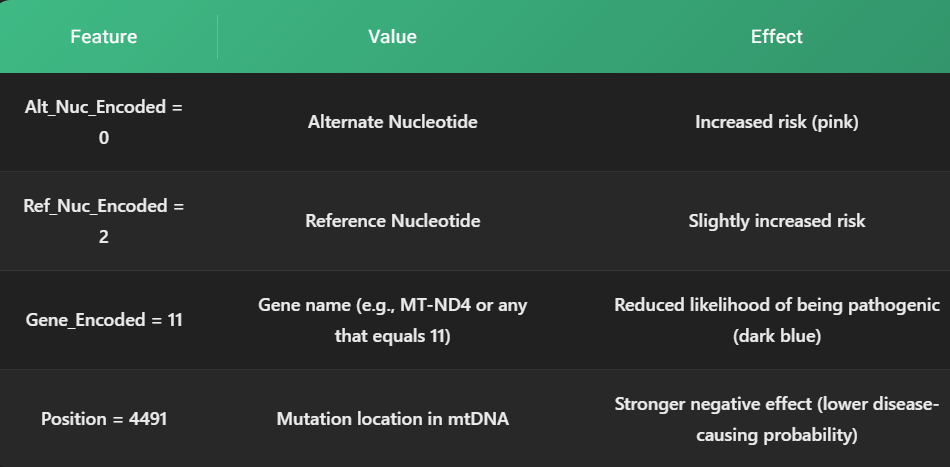

  ##  Final Conclusion
The probability of pathogenicity for this mutation is approximately zero (0.00).

This is because the impact of the blue features (decreasing factors) was significantly stronger than the pink ones.